In [80]:
import pandas as pd
import h2o
from h2o.automl import H2OAutoML
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error

from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [2]:
df = pd.read_csv("input/normal_measures.csv", index_col = 0)

In [3]:
df.head()

,distance,speed,temp_inside,temp_outside,gas_type_E10,gas_type_SP98,external_temp_COLD,external_temp_HOT,consume
0,0.368714,-1.172804,-0.425643,0.091908,1.193734,-1.193734,0.362209,-0.362209,5.0
1,-0.338044,-0.878274,-0.425643,0.235123,1.193734,-1.193734,0.362209,-0.362209,4.2
2,-0.373381,-0.289216,-0.425643,0.521552,1.193734,-1.193734,0.362209,-0.362209,5.5
3,-0.298288,-0.436480,-0.425643,0.378338,1.193734,-1.193734,0.362209,-0.362209,3.9
4,-0.050923,0.299843,-0.425643,0.521552,1.193734,-1.193734,0.362209,-0.362209,4.5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388 entries, 0 to 387
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   distance            388 non-null    float64
 1   speed               388 non-null    float64
 2   temp_inside         376 non-null    float64
 3   temp_outside        388 non-null    float64
 4   gas_type_E10        388 non-null    float64
 5   gas_type_SP98       388 non-null    float64
 6   external_temp_COLD  388 non-null    float64
 7   external_temp_HOT   388 non-null    float64
 8   consume             388 non-null    float64
dtypes: float64(9)
memory usage: 30.3 KB


In [5]:
y = df.consume
X = df[['distance', 'speed', 'temp_inside', 'temp_outside', 'gas_type_E10','gas_type_SP98', 
        'external_temp_COLD', 'external_temp_HOT']]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
train = pd.concat([X_train,y_train], axis = 1)
test = pd.concat([X_test,y_test], axis = 1)

In [7]:
train.to_csv("input/train.csv")
test.to_csv("input/test.csv")

# Init H2O cluster

In [8]:
h2o.init();

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.261-b12, mixed mode)
  Starting server from C:\Users\UX533F\AppData\Local\Programs\Python\Python38-32\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\UX533F\AppData\Local\Temp\tmpyi4z_5gb
  JVM stdout: C:\Users\UX533F\AppData\Local\Temp\tmpyi4z_5gb\h2o_UX533F_started_from_python.out
  JVM stderr: C:\Users\UX533F\AppData\Local\Temp\tmpyi4z_5gb\h2o_UX533F_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Paris
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.3
H2O_cluster_version_age:,24 days
H2O_cluster_name:,H2O_from_python_UX533F_vf2qqc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.516 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


In [9]:
print('Loading dataset.')
train = h2o.import_file("input/train.csv")
test = h2o.import_file("input/test.csv")

Loading dataset.
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


# Init processing

In [10]:
x = train.columns # columns used for training
y = "consume"     # target column
x.remove(y)       # remove target from X

In [91]:
automl = H2OAutoML(max_runtime_secs=600)
automl.train(x=x, y=y, training_frame=train)

AutoML progress: |█
01:40:03.337: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████| 100%


# Predictions

In [92]:
predictions = automl.predict(test)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [93]:
guess = predictions.as_data_frame()
real = test['consume'].as_data_frame()

In [94]:
r2 = r2_score(y_true = real, y_pred = guess)
rmse = mean_squared_error(y_true = real, y_pred = guess)**0.5
r2, rmse

(0.8596231968826253, 0.34323150220128706)

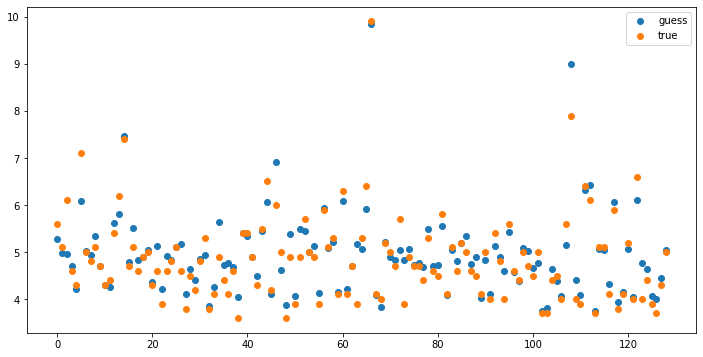

In [96]:
plt.figure(figsize=(12,6))
plt.scatter(y=guess['predict'], x = range(0,len(guess)), label = "guess");
plt.scatter(y=real['consume'], x = range(0,len(real)),label = "true");
plt.legend();